# Chapter 06 — Downsampled Data Filtered Basic Analysis

### Objective

In this chapter, we AnnDatas from previous chapters and create plots from the QC metrics computed by Scanpy, as well as some simple gene set enrichment analysis (apotosis and housekeeping genes). We will be using the downsampled data that we generated in Chapter 02.

This includes:

- Reading in AnnDatas from the correct input directory
- Plotting histograms and violin plots for every relevant metric in adata.obs
- Saving the AnnDatas with updated gene set enrichment analysis to the correct output directory

### Data Inputs and Outputs

- AnnDatas will come from "adatas/adatas_X_filtered_cells_raw_with_downsampled_layer"
- Updated AnnDatas will be outputed to "adatas/adatas_X_downsampled_with_gene_metrics"
- Figures will be outputted to "fig
 
### How Does This Tie Back to the Big Picture (Comparing/Benchmarking Protocols)?

- These basic QC metrics from Scanpy can directly tell us whether we get better quality cells from one protocol or another
- Getting more quality cells would allow us to gain more biological insights and therefore would make one protocol better than the other
- Running this on downsampled data should allow us to make a better comparison between the protocols and remove any technical bias created by differences in sequencing depth (which is not necessarily dependent on the protocol itself)
  
<br>

---




##### Run Autoreload (Automically Reloads Edited Module Files)

In [1]:
%load_ext autoreload
%autoreload 2

#### Imports

In [2]:
import os
import scanpy as sc
from typing import List, Tuple, Dict

import utils
import utils.config as config

### File Paths

In [3]:
# File and directory paths
figures_output_dir = config.FIGURES_DIR / "chapter_06_downsampled_basic_analysis"
input_adata_dir = config.ADATA_DIR / "adatas_X_filtered_cells_raw_with_downsampled_layer"
output_adata_dir = config.ADATA_DIR / "adatas_X_downsampled_with_gene_metrics"

# Make sure output directories exist
os.makedirs(figures_output_dir, exist_ok=True)
os.makedirs(output_adata_dir, exist_ok=True)

### Read in AnnDatas

In [4]:
# Load AnnData objects
adata_dict = {}
sample_metadata = config.SAMPLES_METADATA

for key, sample_info in sample_metadata.items():
    tissue = sample_info["tissue"]
    protocol = sample_info["protocol"]

    file_path = os.path.join(
        input_adata_dir,
        f"{key}_adata.h5ad",
    )

    adata = sc.read_h5ad(file_path)
    adata_dict[key] = adata
    print(f"{key}: {adata}")

SF_N: AnnData object with n_obs × n_vars = 7179 × 32527
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'downsampled_umi'
SL_N: AnnData object with n_obs × n_vars = 7929 × 33481
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'downsampled_umi'
SF_T: AnnData object with n_obs × n_vars = 7146 × 31710
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by

### Switch to Downsampled Layer and Calculate QC Metrics

We'll set adata.X to the downsampled layer and reacalculate the basic QC metrics from Scanpy here

In [5]:
def switch_layers_and_run_qc_metrics(adata) -> None:
    """
    Compute standard quality control (QC) metrics on an AnnData object.

    Args:
        adata (AnnData): Annotated data matrix of shape n_obs x n_vars.

    Returns:
        None: Modifies the input AnnData object in-place by adding QC metrics to `adata.obs` and `adata.var`.
    """
    adata.layers["not_downsampled_raw"] = adata.X.copy()  # Store original data
    adata.X = adata.layers["downsampled_umi"]

    sc.pp.calculate_qc_metrics(
        adata,
        inplace=True,
        percent_top=None,
    )

    adata.var_names_make_unique()
    adata.obs_names_make_unique()
    return


# Run QC metrics on each dataset
for adata in adata_dict.values():
    switch_layers_and_run_qc_metrics(adata)
    print(adata)


AnnData object with n_obs × n_vars = 7179 × 32527
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'downsampled_umi', 'not_downsampled_raw'
AnnData object with n_obs × n_vars = 7929 × 33481
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'downsampled_umi', 'not_downsampled_raw'
AnnData object with n_obs × n_vars = 7146 × 31710
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_m

### Generate Plots

#### Plot Number of Cells by Protocol Across Tissues

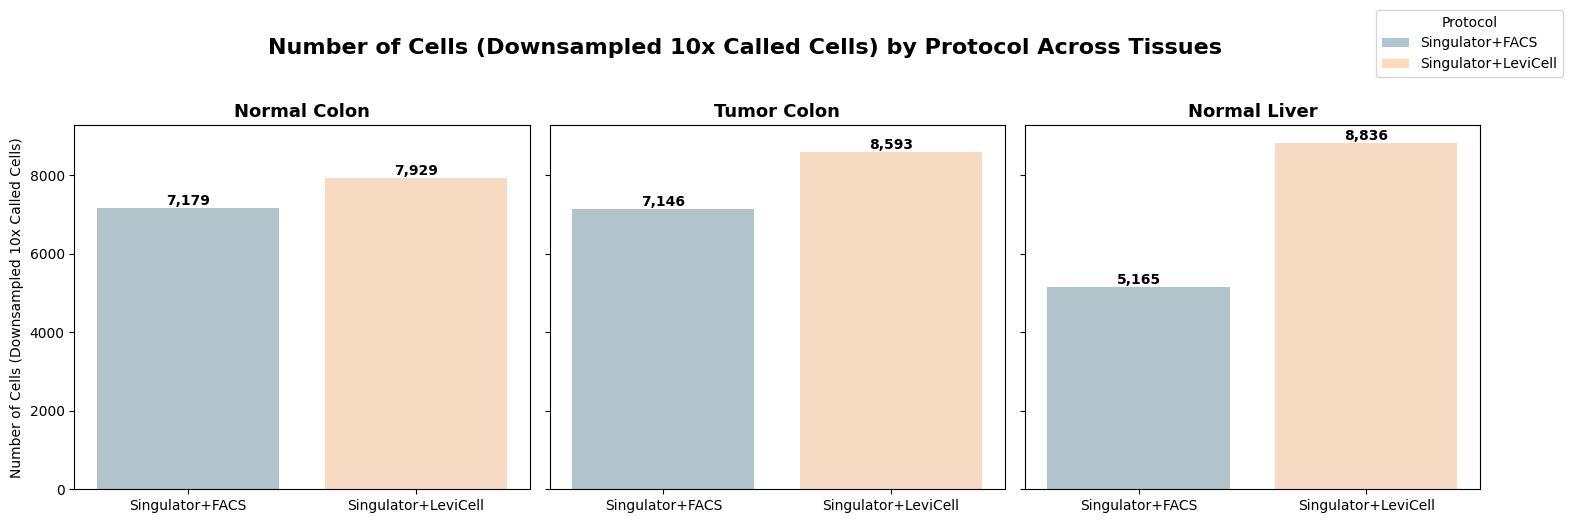

In [6]:
protocol_color_palette = config.PROTOCOL_COLOR_PALETTE
tissue_order = config.TISSUE_ORDER

# Plot number of cells
fig = utils.plot_scalar_metric(
    data_dict=adata_dict,
    metadata=sample_metadata,
    metric_func=lambda adata: adata.n_obs,
    metric_label="Number of Cells (Downsampled 10x Called Cells)",
    protocol_color_palette=protocol_color_palette,
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(os.path.join(figures_output_dir, "num_cells.png"), bbox_inches="tight")

### Plot Total UMIs

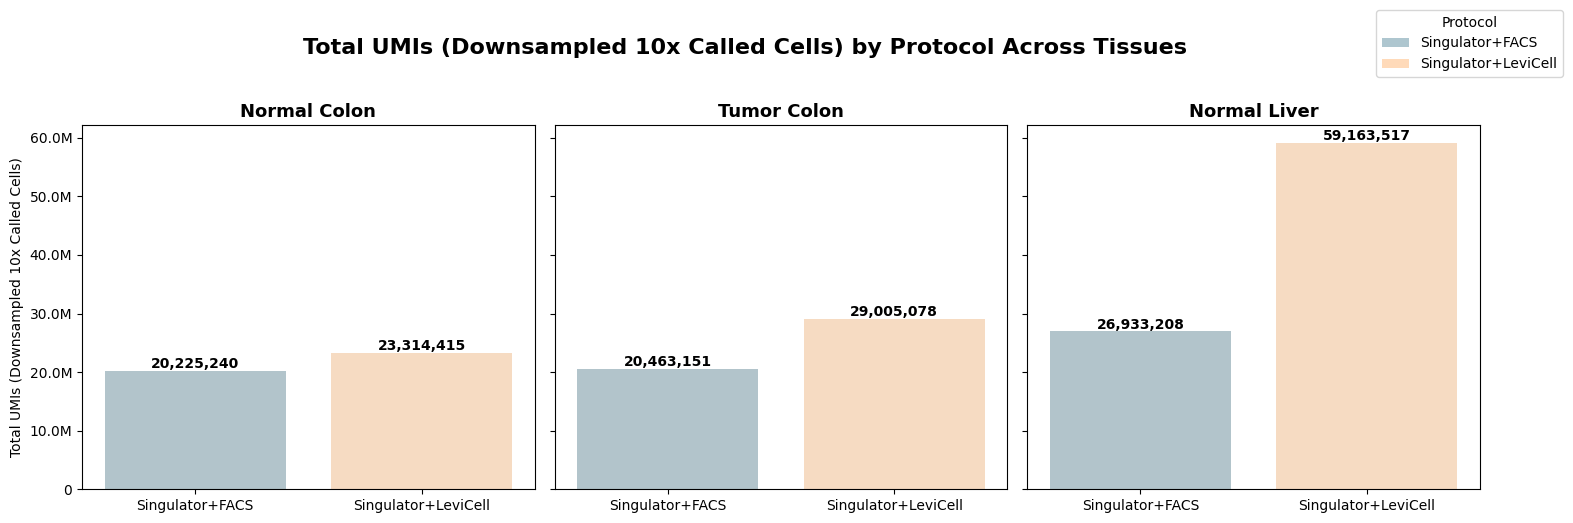

In [7]:
# Plot total UMIs
fig = utils.plot_scalar_metric(
    data_dict=adata_dict,
    metadata=sample_metadata,
    metric_func=lambda adata: adata.X.sum(),
    metric_label="Total UMIs (Downsampled 10x Called Cells)",
    protocol_color_palette=protocol_color_palette,
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(os.path.join(figures_output_dir, "total_umis.png"), bbox_inches="tight")

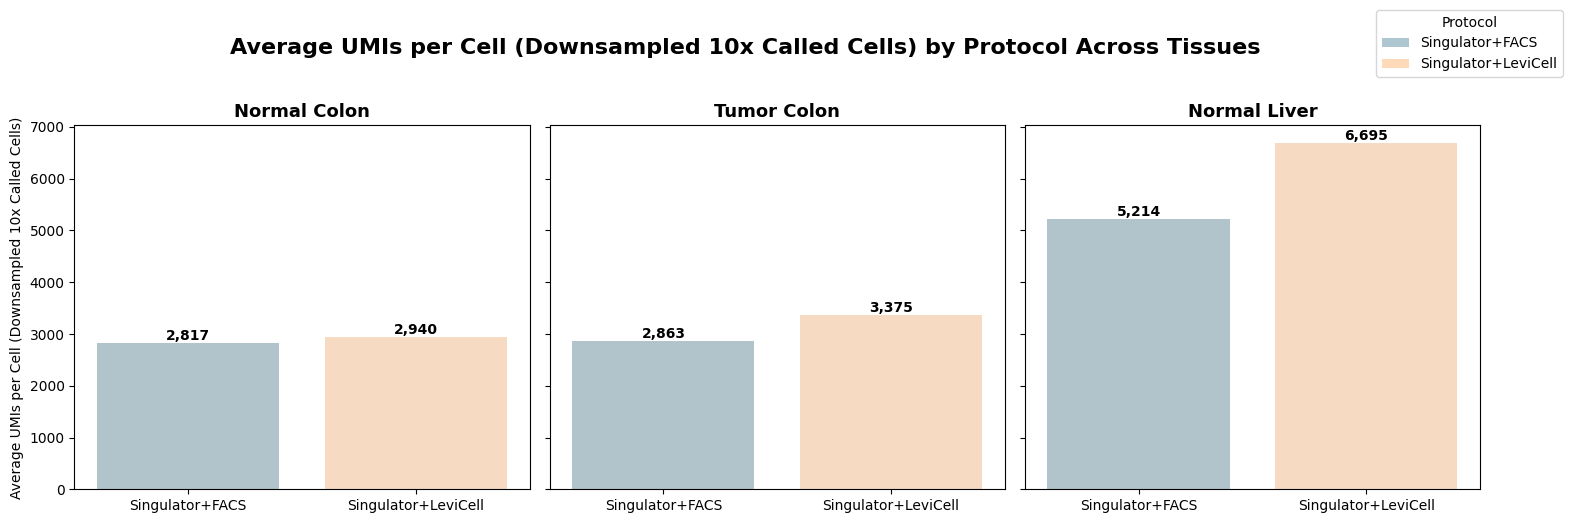

In [8]:
# Plot average UMIs per cell
fig = utils.plot_scalar_metric(
    data_dict=adata_dict,
    metadata=sample_metadata,
    metric_func=lambda adata: adata.X.sum() / adata.n_obs,
    metric_label="Average UMIs per Cell (Downsampled 10x Called Cells)",
    protocol_color_palette=protocol_color_palette,
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "average_umis_per_cell.png"), bbox_inches="tight"
)

### Plot Library Size Distribution

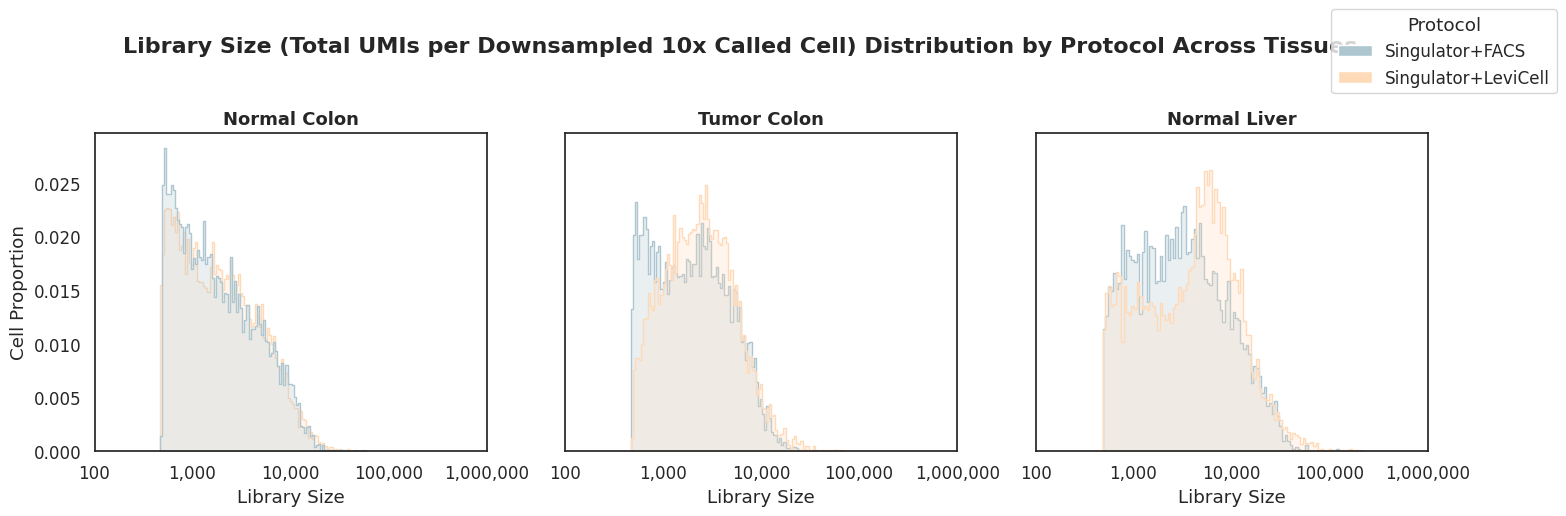

In [9]:
# Plot library size histogram
fig = utils.plot_adata_metric_histogram(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="total_counts",
    axis="obs",
    log_x=True,
    x_label="Library Size",
    title="Library Size (Total UMIs per Downsampled 10x Called Cell) Distribution by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "library_size_hist.png"), bbox_inches="tight"
)

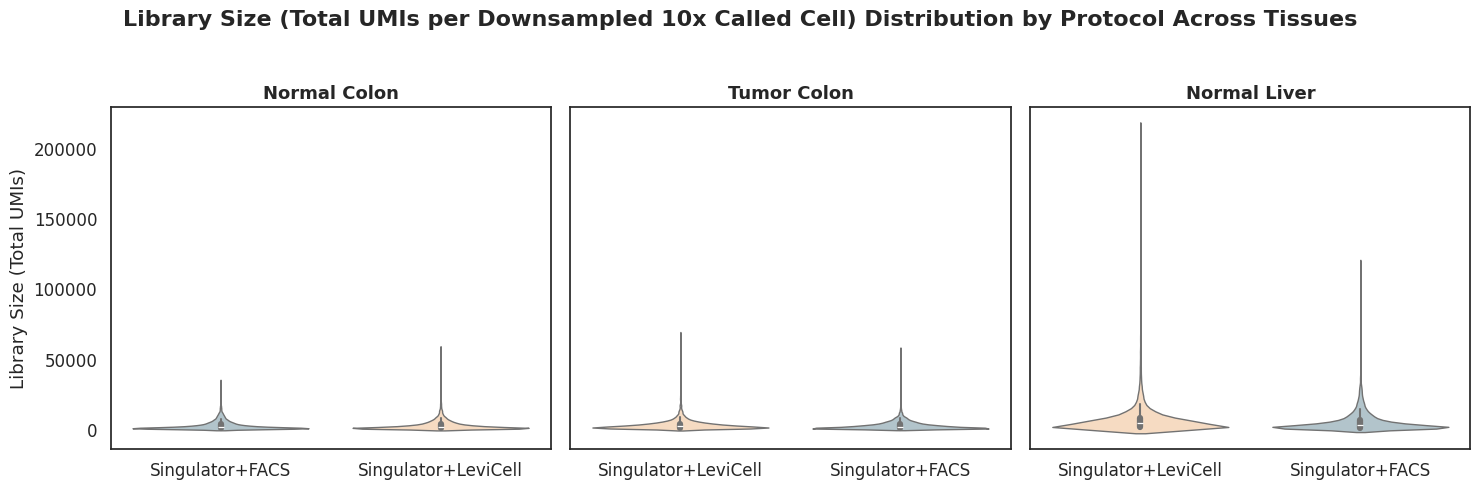

In [10]:
# Plot library size violin plot
fig = utils.plot_adata_metric_violin(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="total_counts",
    axis="obs",
    y_label="Library Size (Total UMIs)",
    title="Library Size (Total UMIs per Downsampled 10x Called Cell) Distribution by Protocol Across Tissues",
    log_y=False,
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "library_size_violin.png"), bbox_inches="tight"
)

### Plot Number of Genes per Cell

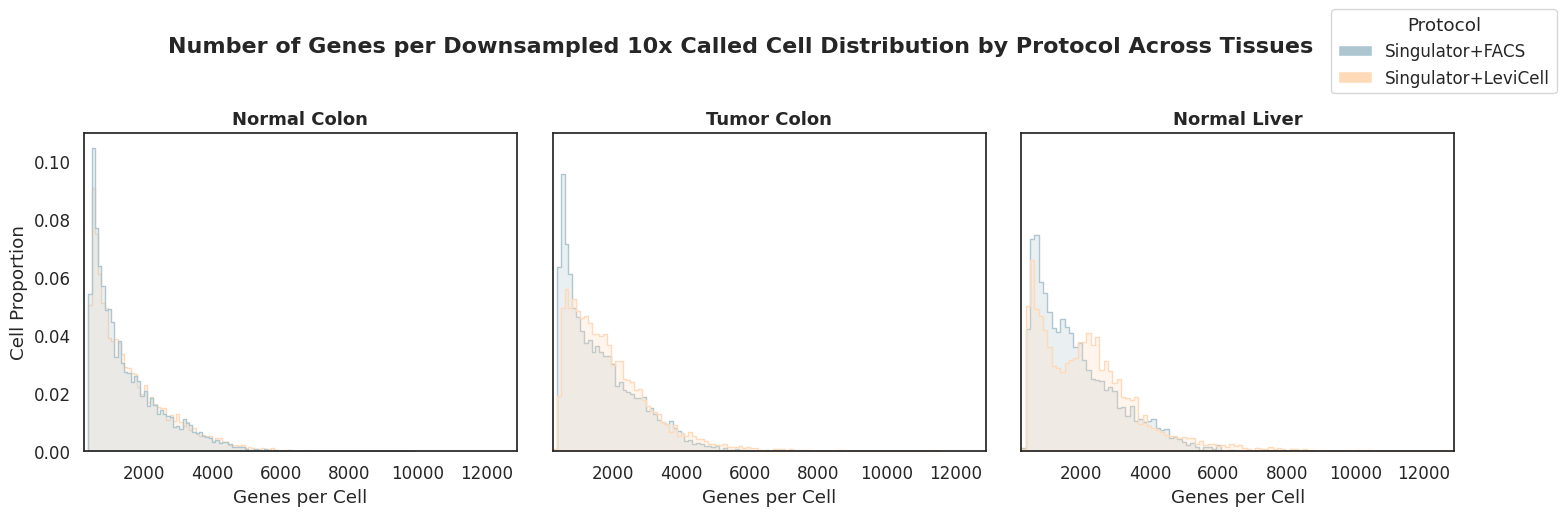

In [11]:
# Plot number of genes per cell
fig = utils.plot_adata_metric_histogram(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="n_genes_by_counts",
    axis="obs",
    log_x=False,
    x_label="Genes per Cell",
    title="Number of Genes per Downsampled 10x Called Cell Distribution by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "genes_per_cell_hist.png"), bbox_inches="tight"
)

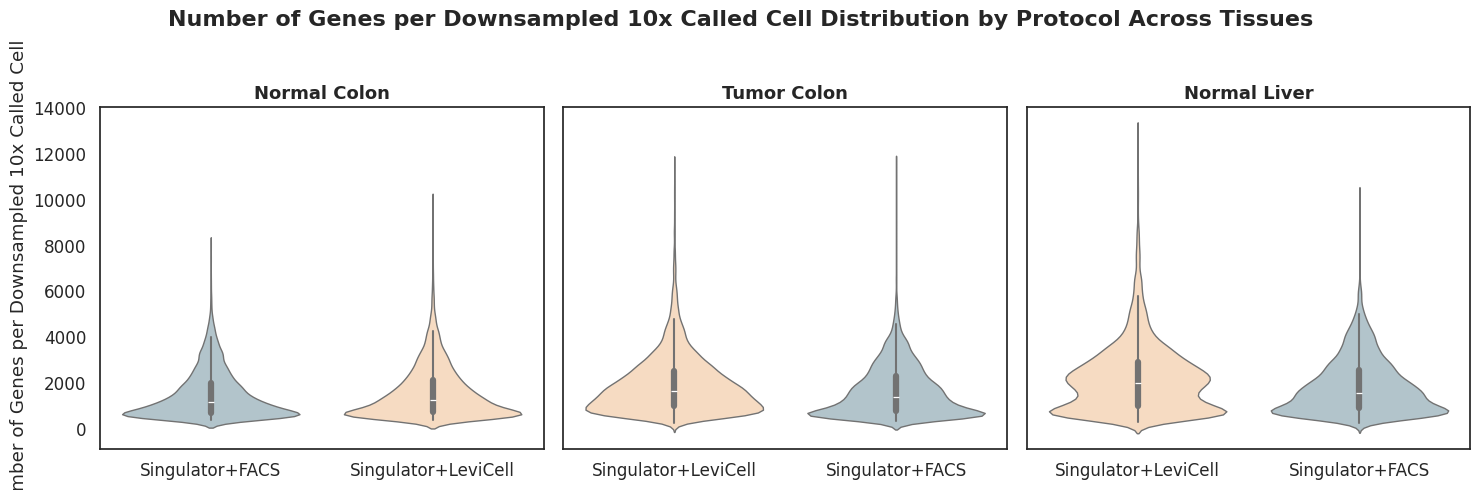

In [ ]:
# Plot number of genes per cell violin plot
fig = utils.plot_adata_metric_violin(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="n_genes_by_counts",
    axis="obs",
    y_label="Number of Genes",
    title="Number of Genes per Downsampled 10x Called Cell Distribution by Protocol Across Tissues",
    log_y=False,
    protocol_color_palette=protocol_color_palette,
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "genes_per_cell_violin.png"), bbox_inches="tight"
)

### Gene Detection

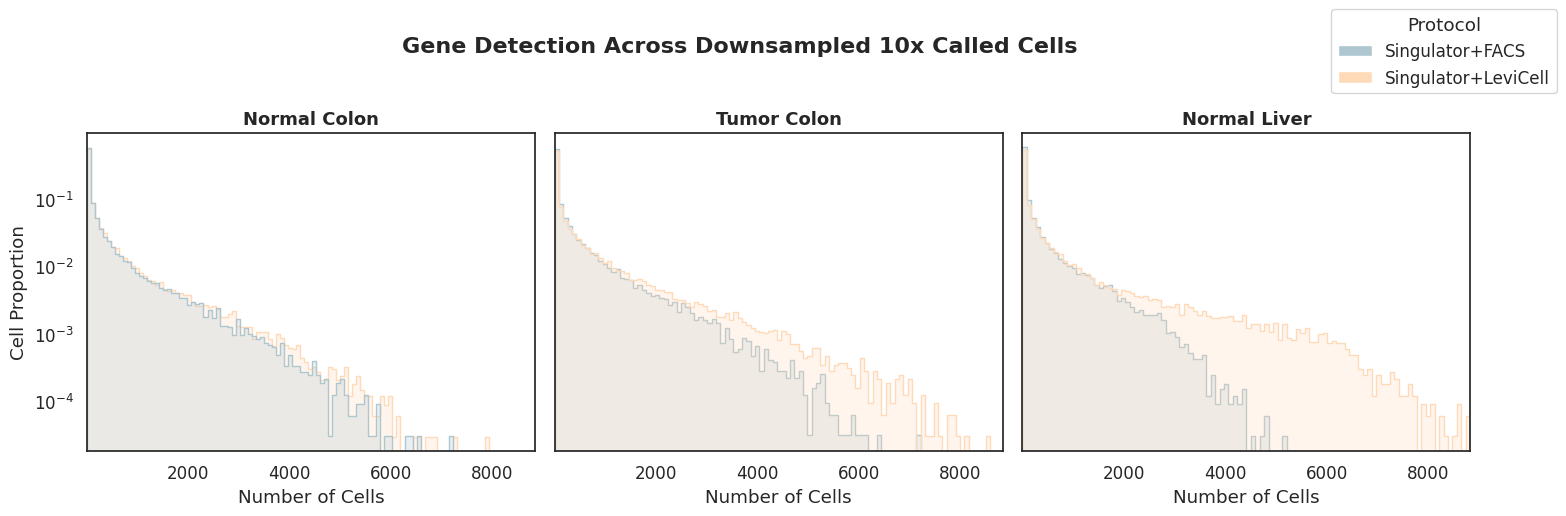

In [13]:
# Plot number of cells per gene histogram
fig = utils.plot_adata_metric_histogram(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="n_cells_by_counts",
    axis="var",
    log_x=False,
    log_y=True,
    x_label="Number of Cells",
    title="Gene Detection Across Downsampled 10x Called Cells",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(os.path.join(figures_output_dir, "gene_detection.png"), bbox_inches="tight")

### Compute Mitochondrial and Ribosomal Gene Count Percentages

#### Functions

- compute_gene_category_qc_metrics: Annotates genes based ona a pattern (eg. "MT-" for human mitochondrial)
- add_gene_set_content_to_adata_dict: Takes in a set of genes and computes the percent content of those genes on a per cell basis

In [14]:
def compute_gene_category_qc_metrics(
    adata_dict: Dict[str, sc.AnnData],
    category_label: str,
    pattern: str | List[str] | Tuple[str],
) -> None:
    """
    Annotate genes based on a pattern and compute QC metrics for each AnnData in the dict.

    Args:
        adata_dict: dict with keys like 'sf_t', 'sl_t', etc. and values as AnnData objects
        category_label: name of the category to annotate (e.g., "mitochondrial", "ribosomal")
        pattern: prefix string, tuple of prefixes, or list of prefixes to match gene names
    """
    for adata in adata_dict.values():
        adata.var[category_label] = adata.var_names.str.startswith(pattern)
        sc.pp.calculate_qc_metrics(
            adata,
            qc_vars=[category_label],
            percent_top=None,
            log1p=False,
            inplace=True,
        )
    return


def add_gene_set_content_to_adatas(
    adata_dict: Dict[str, sc.AnnData], gene_set: List[str], gene_set_name: str
) -> None:
    """
    Annotate and compute percent content for a specific gene set (e.g. apoptosis or housekeeping)
    across all AnnData objects in a dictionary.

    Args:
        adata_dict: dict of AnnData objects keyed by sample label
        gene_set: list of gene symbols representing the gene set
        gene_set_name: string label for the gene set (e.g., 'apoptosis', 'housekeeping')
    """
    for adata in adata_dict.values():
        filtered_genes = list(set(gene_set) & set(adata.var_names))
        print(
            f"{adata.obs.shape[0]} cells | {len(filtered_genes)} {gene_set_name} genes found"
        )

        # Mark genes belonging to the gene set
        adata.var[gene_set_name] = adata.var_names.isin(filtered_genes)

        # Calculate percent content using scanpy
        sc.pp.calculate_qc_metrics(
            adata, qc_vars=[gene_set_name], percent_top=None, log1p=False, inplace=True
        )

    return


#### Compute Gene Percentage Metrics

In [15]:
# Compute mitochondrial QC metrics
compute_gene_category_qc_metrics(
    adata_dict=adata_dict, category_label="mitochondrial", pattern="MT-"
)

# Compute ribosomal QC metrics
compute_gene_category_qc_metrics(
    adata_dict=adata_dict, category_label="ribosomal", pattern=("RPS", "RPL")
)

### Plot Mitochondrial Results

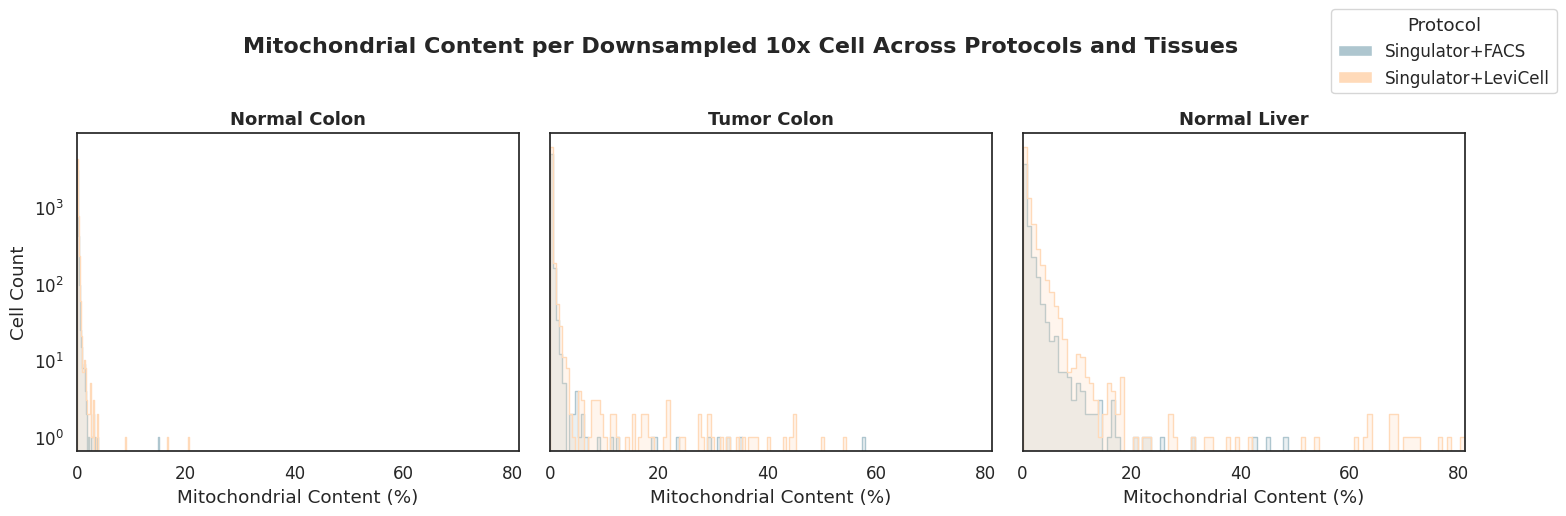

In [16]:
# Plot mitochondrial content percentage histogram
fig = utils.plot_adata_metric_histogram(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="pct_counts_mitochondrial",
    axis="obs",
    log_x=False,
    log_y=True,
    x_label="Mitochondrial Content (%)",
    title="Mitochondrial Content per Downsampled 10x Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "mitochondrial_percentage_hist.png"),
    bbox_inches="tight",
)

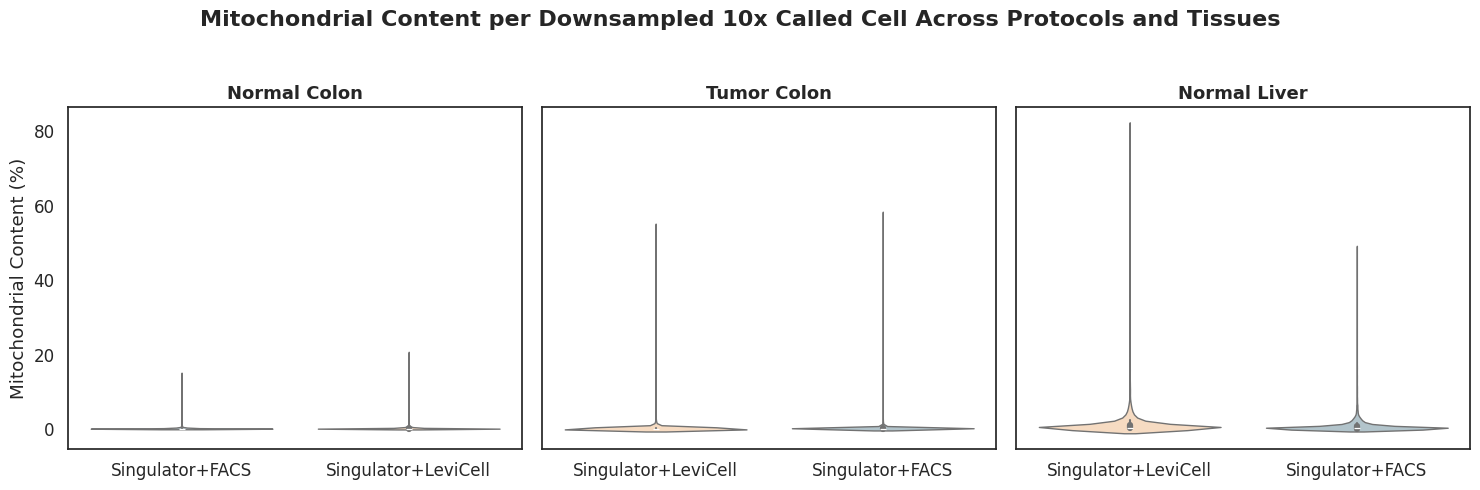

In [17]:
# Plot mitochondrial content percentage violin plot
fig = utils.plot_adata_metric_violin(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="pct_counts_mitochondrial",
    axis="obs",
    log_y=False,
    y_label="Mitochondrial Content (%)",
    title="Mitochondrial Content per Downsampled 10x Called Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "mitochondrial_percentage_violin.png"),
    bbox_inches="tight",
)

### Plot Ribosomal Results

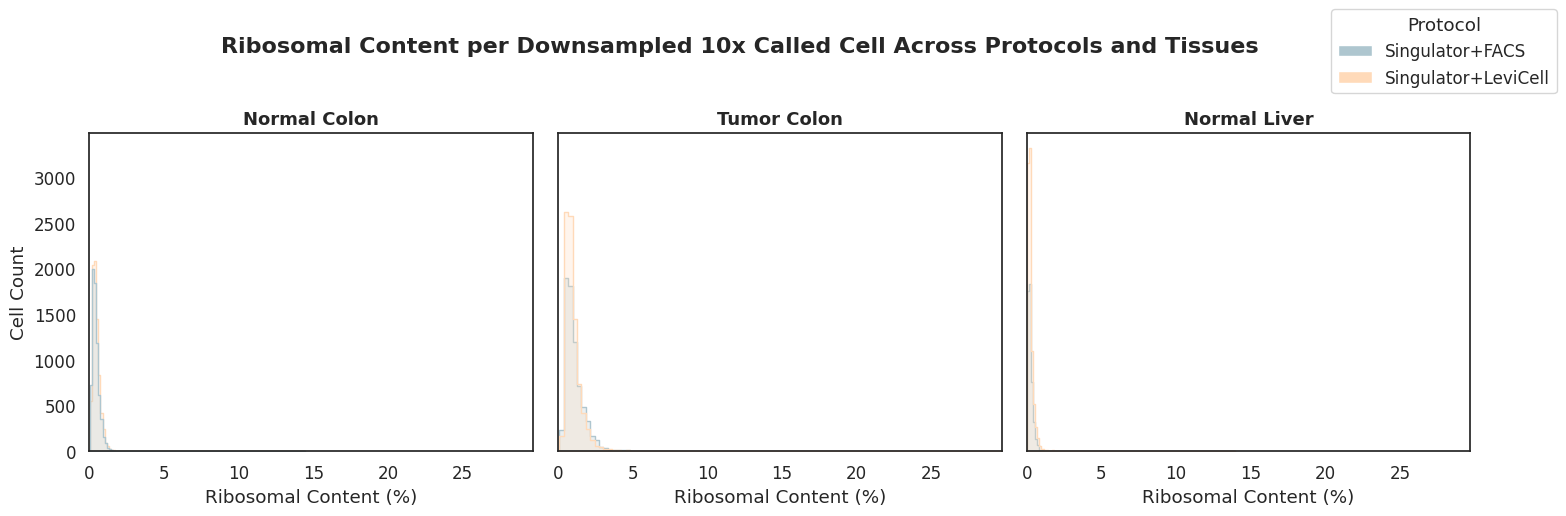

In [18]:
# Plot ribosomal content percentage histogram
fig = utils.plot_adata_metric_histogram(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="pct_counts_ribosomal",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Ribosomal Content (%)",
    title="Ribosomal Content per Downsampled 10x Called Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "ribosomal_percentage_hist.png"),
    bbox_inches="tight",
)

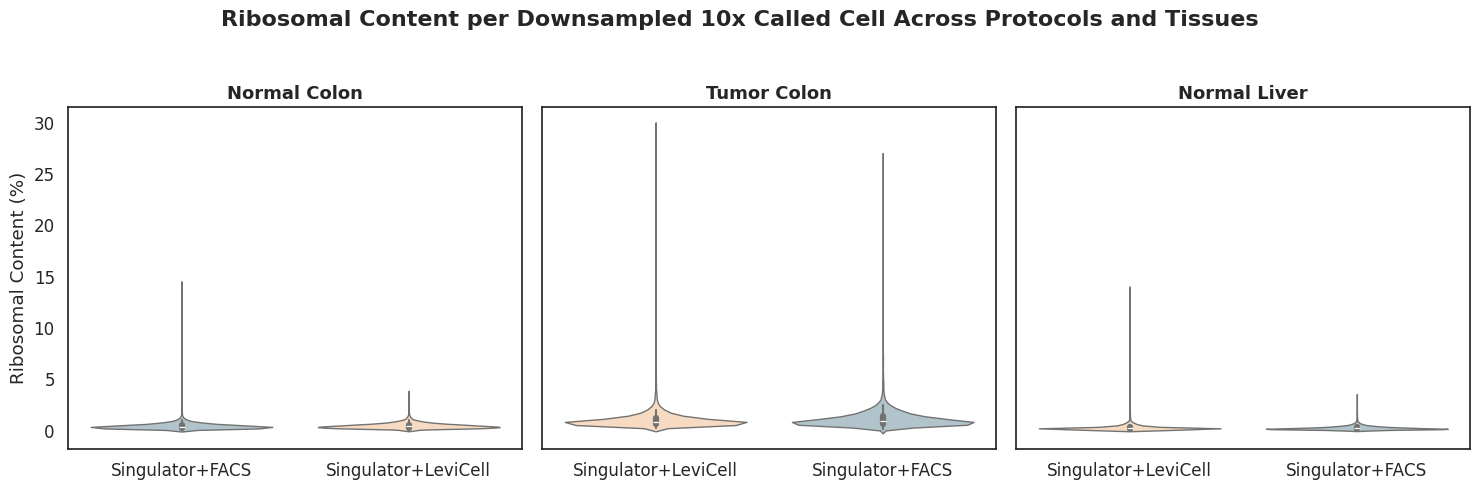

In [26]:
# Plot ribosomal content percentage violin plot
fig = utils.plot_adata_metric_violin(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="pct_counts_ribosomal",
    axis="obs",
    log_y=False,
    y_label="Ribosomal Content (%)",
    title="Ribosomal Content per Downsampled 10x Called Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "ribosomal_percentage_violin.png"),
    bbox_inches="tight",
)

### Compare Gene Set Content

#### Run functions

In [20]:
gene_set_info_dir = config.GENE_SET_INFO_DIR

# Load apoptosis gene list (from Rahul)
with open(os.path.join(gene_set_info_dir, "apoptosis_genes.txt")) as f:
    apoptosis_genes = f.read().splitlines()

# Load housekeeping gene list from (https://www.gsea-msigdb.org/gsea/msigdb/cards/HOUNKPE_HOUSEKEEPING_GENES)
with open(os.path.join(gene_set_info_dir, "housekeeping_genes.txt")) as f:
    housekeeping_genes = f.read().splitlines()
# Annotate and compute
add_gene_set_content_to_adatas(adata_dict = adata_dict, gene_set= apoptosis_genes, gene_set_name="apoptosis")
add_gene_set_content_to_adatas(
    adata_dict = adata_dict, gene_set= housekeeping_genes, gene_set_name="housekeeping"
)

7179 cells | 156 apoptosis genes found
7929 cells | 158 apoptosis genes found
7146 cells | 157 apoptosis genes found
8593 cells | 158 apoptosis genes found
5165 cells | 158 apoptosis genes found
8836 cells | 158 apoptosis genes found
7179 cells | 1129 housekeeping genes found
7929 cells | 1129 housekeeping genes found
7146 cells | 1129 housekeeping genes found
8593 cells | 1129 housekeeping genes found
5165 cells | 1129 housekeeping genes found
8836 cells | 1129 housekeeping genes found


### Plot Apoptosis Results

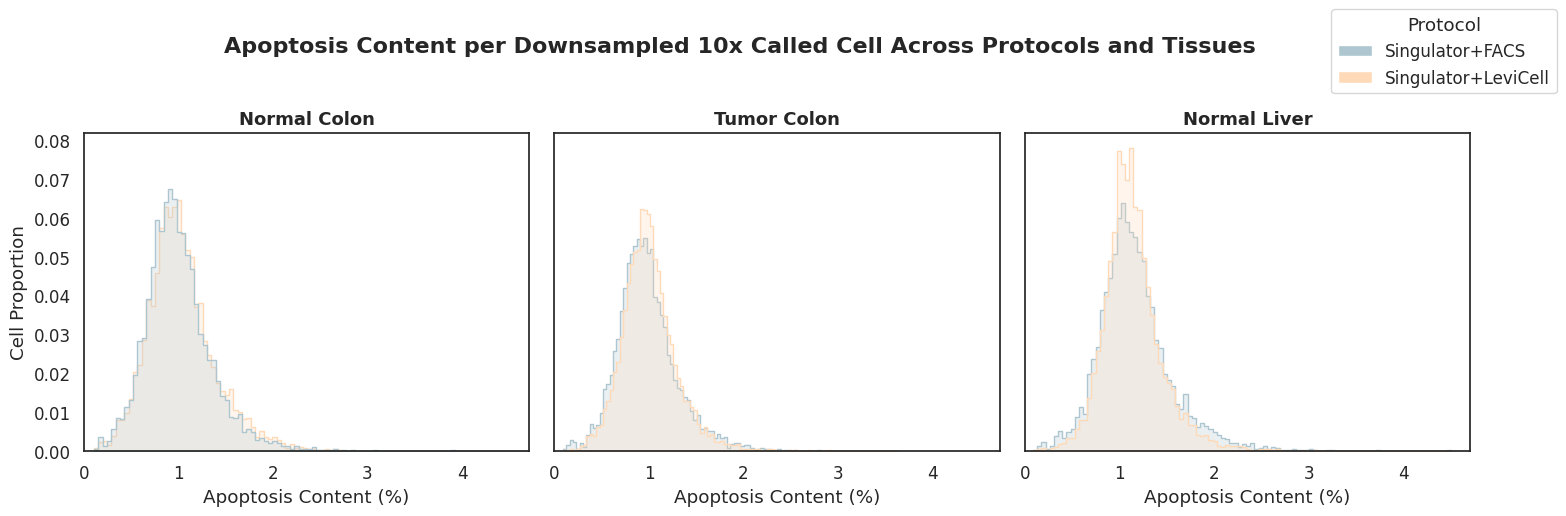

In [21]:
# Plot apoptosis content percentage histogram
fig = utils.plot_adata_metric_histogram(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="pct_counts_apoptosis",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Apoptosis Content (%)",
    title="Apoptosis Content per Downsampled 10x Called Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "apoptosis_percentage_hist.png"),
    bbox_inches="tight",
)

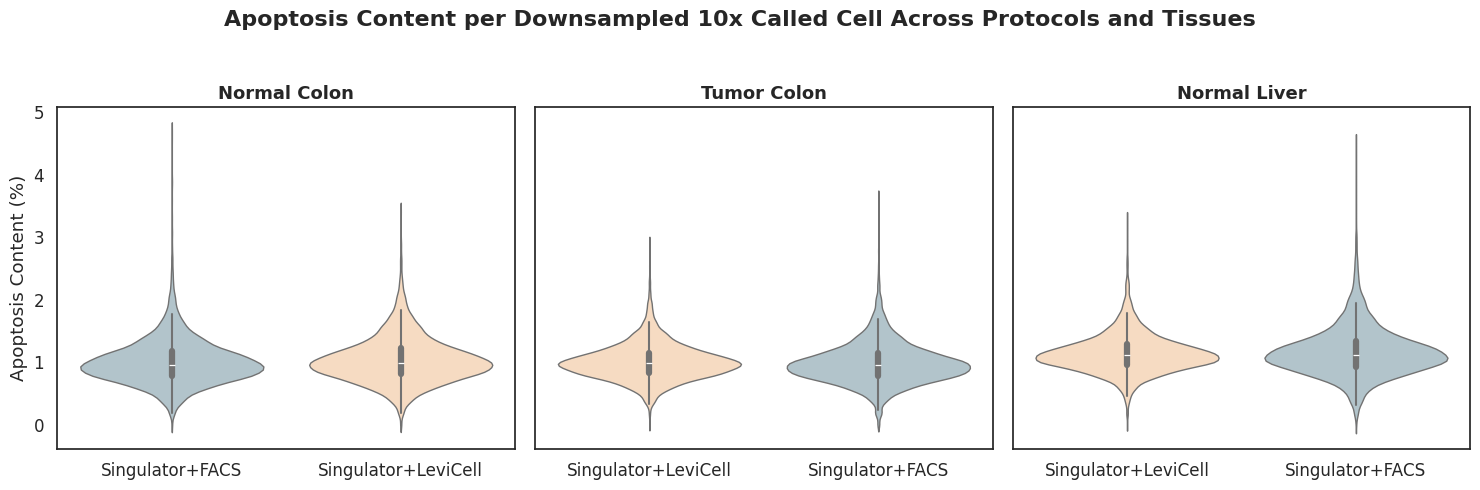

In [22]:
# Plot apoptosis content percentage violin plot
fig = utils.plot_adata_metric_violin(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="pct_counts_apoptosis",
    axis="obs",
    log_y=False,
    y_label="Apoptosis Content (%)",
    title="Apoptosis Content per Downsampled 10x Called Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "apoptosis_percentage_violin.png"),
    bbox_inches="tight",
)

### Plot Housekeeping Results

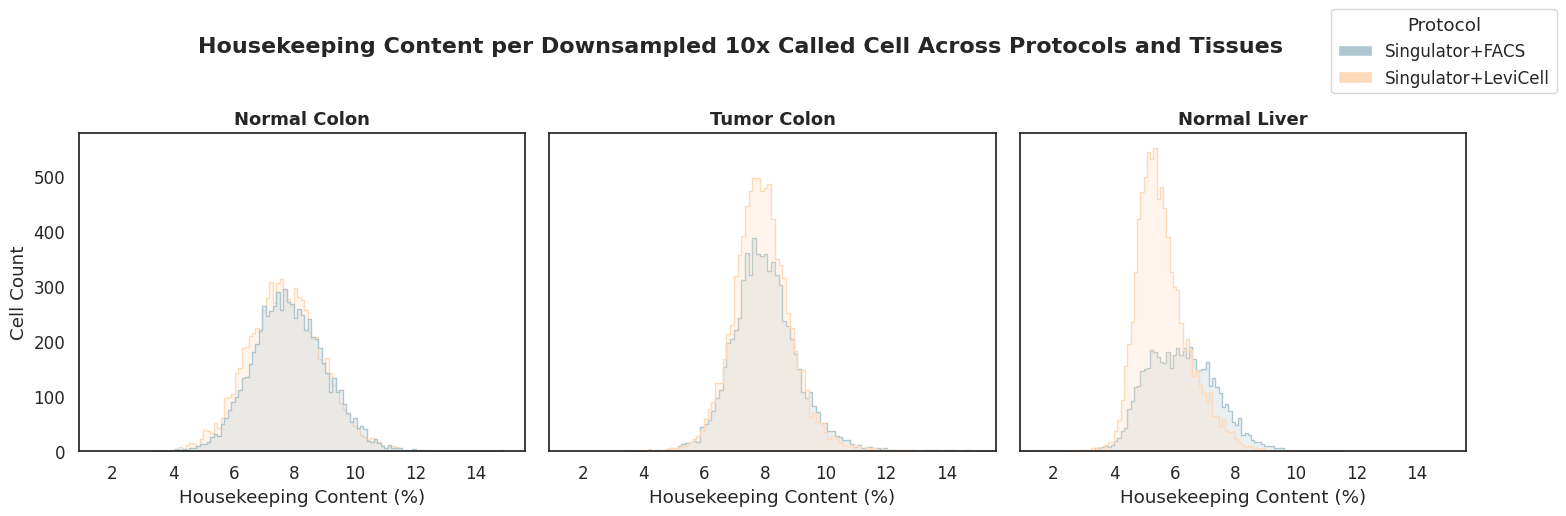

In [23]:
# Plot housekeeping content percentage histogram
fig = utils.plot_adata_metric_histogram(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="pct_counts_housekeeping",
    axis="obs",
    log_x=False,
    log_y=False,
    x_label="Housekeeping Content (%)",
    title="Housekeeping Content per Downsampled 10x Called Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "housekeeping_percentage_hist.png"),
    bbox_inches="tight",
)

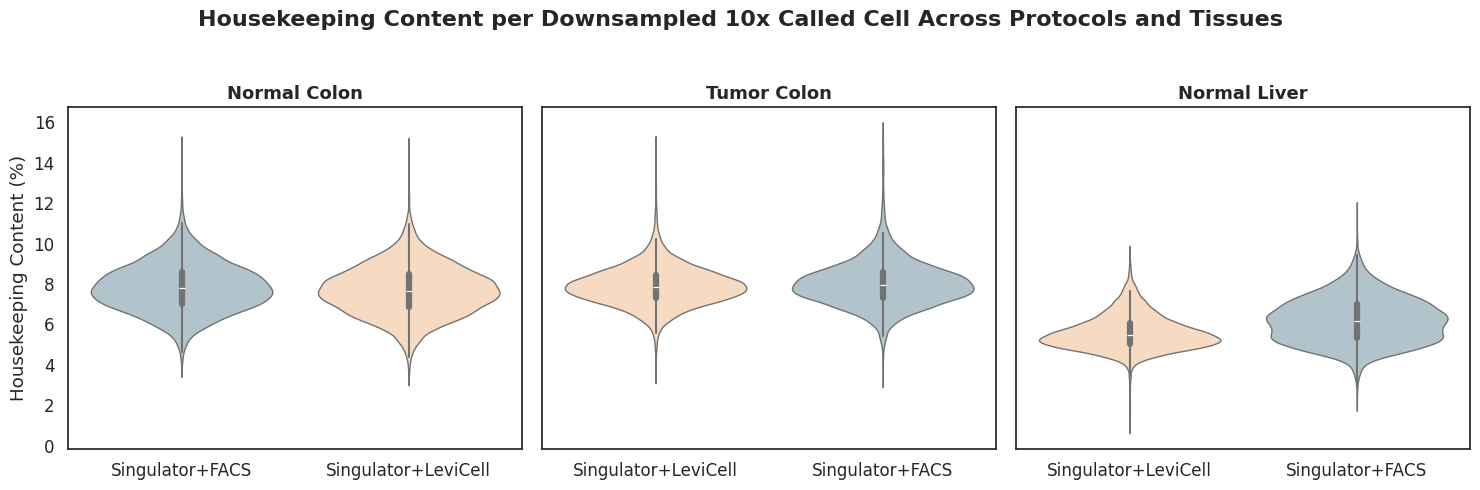

In [24]:
# Plot housekeeping content percentage violin plot
fig = utils.plot_adata_metric_violin(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="pct_counts_housekeeping",
    axis="obs",
    log_y=False,
    y_label="Housekeeping Content (%)",
    title="Housekeeping Content per Downsampled 10x Called Cell Across Protocols and Tissues",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "housekeeping_percentage_violin.png"),
    bbox_inches="tight",
)

## Save AnnDatas to File

In [25]:
for key, sample_info in sample_metadata.items():
    tissue = sample_info["tissue"]
    protocol = sample_info["protocol"]

    out_path = os.path.join(output_adata_dir, f"{key}_adata.h5ad")
    adata_dict[key].write(out_path)
    print(f"Saved {key}_adata to {out_path}")

Saved SF_N_adata to /data1/collab002/sail/projects/ongoing/benchmarks/sail-benchmarking-template/utils/../data/adatas/adatas_X_downsampled_with_gene_metrics/SF_N_adata.h5ad
Saved SL_N_adata to /data1/collab002/sail/projects/ongoing/benchmarks/sail-benchmarking-template/utils/../data/adatas/adatas_X_downsampled_with_gene_metrics/SL_N_adata.h5ad
Saved SF_T_adata to /data1/collab002/sail/projects/ongoing/benchmarks/sail-benchmarking-template/utils/../data/adatas/adatas_X_downsampled_with_gene_metrics/SF_T_adata.h5ad
Saved SL_T_adata to /data1/collab002/sail/projects/ongoing/benchmarks/sail-benchmarking-template/utils/../data/adatas/adatas_X_downsampled_with_gene_metrics/SL_T_adata.h5ad
Saved SF_LN_adata to /data1/collab002/sail/projects/ongoing/benchmarks/sail-benchmarking-template/utils/../data/adatas/adatas_X_downsampled_with_gene_metrics/SF_LN_adata.h5ad
Saved SL_LN_adata to /data1/collab002/sail/projects/ongoing/benchmarks/sail-benchmarking-template/utils/../data/adatas/adatas_X_downs